# HW1

## 0)导入numpy以及实验数据

In [1]:
import numpy as np # 用于实现网络
import pandas as pd # 用于存储网络结构
import tqdm # 用于可视化搜参进度

import itertools # 用于实现笛卡尔积 简化搜参代码
import matplotlib.pyplot as plt # 用于可视化loss曲线、acc曲线以及网络参数

from torchvision import datasets,transforms # 用于下载数据集
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,auc,roc_curve

In [2]:
train_data = datasets.MNIST(root="./MNIST",
                            train=True,
                            transform=transforms.ToTensor(),
                            download=False)

# train_data 共有60000个样本，在这里重新划分为了前50000为train_set，后10000为val_set
train_set_x=np.concatenate([train_data[i][0].numpy().reshape(-1,1) for i in range(50000)],axis=1)
val_set_x=np.concatenate([train_data[i][0].numpy().reshape(-1,1) for i in range(50000,60000)],axis=1)
train_set_y=[train_data[i][1] for i in range(50000)]
val_set_y=[train_data[i][1] for i in range(50000,60000)]

test_data = datasets.MNIST(root="./MNIST",
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)
test_set_x=np.concatenate([test_data[i][0].numpy().reshape(-1,1) for i in range(10000)],axis=1)
test_set_y=[test_data[i][1] for i in range(10000)]

## 1)实现线性层、激活函数层、Softmax层（与loss写在一起）

In [4]:
class linear_with_np():
    """
    in_dim:输入维度
    out_dim:输出维度
    trans_mat:线性变换的矩阵
    bias:是否使用偏置项
    bias_mat:偏置项

    方法：
    forward:返回out=wx+b 其中x:p*1,w:m*p,b:m*1,y:m*1
    backward:输入前一层的梯度,返回梯度（三项,分别是对当前的线性变换矩阵的/对当前的偏置项的/对当前层的输入的（返回到上一层的））

    ps:为bp流程更加清楚,将非线性层用另外一个类表示
    """
    def __init__(self,in_dim,out_dim,bias=True) -> None:
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.trans_mat=np.random.normal(0,0.01,(self.out_dim,self.in_dim))
        
        self.bias_mat=0
        self.bias=bias
        if self.bias: 
            self.bias_mat=np.random.normal(0,0.01,(self.out_dim,1))

    def forward(self,x):
        self.x=x
        return np.dot(self.trans_mat,x)+self.bias_mat
    
    def backward(self,grad):
        grad_o=np.dot(self.trans_mat.T,grad)
        grad_w=np.dot(grad,self.x.T)
        grad_b=grad
        if self.bias:
            return grad_o,grad_w,grad_b
        else:
            return grad_o,grad_w


class nonlinear_with_np():
    """
    name:非线性变换的选择 opt:Relu or Leaky_Relu
    alpha:当name为leaky_relu时,控制小于零时的斜率

    方法：
    forward:返回激活后的向量
    backward:返回梯度
    """
    def __init__(self,name,alpha=0.25) -> None:
        self.name=name
        if name=='Leaky_Relu':
            self.alpha=alpha

    def forward(self,x):
        self.x=x
        if self.name=='Relu':
            x_relu=x.copy()
            x_relu[x_relu<0]=0
            return x_relu      
          
        if self.name=='Leaky_Relu':
            x_relu=x.copy()
            x_relu[x_relu<0]=self.alpha*x_relu[x_relu<0]
            return x_relu
    
    def backward(self,grad):

        if self.name=='Relu':
            zero_one_ind=np.ones_like(grad)
            zero_one_ind[self.x<0]=0
            out_grad=grad * zero_one_ind        
        
        if self.name=='Leaky_Relu':
            zero_one_ind=np.ones_like(grad)
            zero_one_ind[self.x<0]=self.alpha
            out_grad=grad * zero_one_ind
        
        return out_grad
            

class softmax_loss():
    """
    o:未经过softmax的output
    y:未经过onehot的label

    方法：
    forward:返回样本所对应的cross_entropy_loss
    backward:返回梯度

    ps:在内部实现了sotmax操作（防止exp的溢出）
    """
    def __init__(self,o,y) -> None:
        self.o=o
        self.y=y

    def forward(self):
        o_copy1=self.o-self.o.mean()
        exp_o=np.exp(o_copy1)
        exp_o=exp_o/(exp_o.sum(axis=0))
        log_exp_o=np.log(exp_o)
        return -log_exp_o[self.y]
    
    def backward(self):
       
        exp_o=np.exp(self.o-self.o.max())
        exp_o=exp_o/(exp_o.sum(axis=0))
        
        exp_o[self.y]-=1
        return exp_o

def softmax(x):
    x_copy=x-x.mean()
    exp_o=np.exp(x_copy)
    exp_o=exp_o/(exp_o.sum(axis=0))
    return exp_o

## 2)实现SGD以及学习率下降策略

In [4]:
class SGD():
    """
    eta_des_time:每间隔eta_des_time次,就将eta*eta_des
    eta_des:学习率衰减的强度
    """
    def __init__(self,eta_des_time,eta_des) -> None:
        self.eta_des_time=eta_des_time
        self.eta_des=eta_des

    def grad_des(self,para_list,grad_list,eta,epoch):
        eta=eta*(self.eta_des**(epoch//self.eta_des_time))
        new_para=[]
        for para,grad in zip(para_list,grad_list):
            para=para-eta*grad
            new_para.append(para)
        return new_para

## 3)实现L2正则化

In [5]:
def L2(para,d_para,alpha=0.25):
    """
    alpha:正则化强度
    """
    return d_para+alpha*para

## 4)实现模型保存

In [6]:
def save_model(layer_list,layer_name,path):
    model_str=pd.DataFrame()
    model_str['type']=layer_name
    model_str['detail']=None
    model_shape=[]
    for layeri,namei in zip(layer_list,layer_name):
        if "nonli" in namei:
            if layeri.name=='Relu':
                model_shape.append(layeri.name)
            else:
                model_shape.append(layeri.name+' '+str(layeri.alpha))
        else:
            model_shape.append((layeri.in_dim,layeri.out_dim,layeri.bias))
            np.save('{0}/{1}+bias.npy'.format(path,namei),layeri.bias_mat)
            np.save('{0}/{1}+trans.npy'.format(path,namei),layeri.trans_mat)
    model_str['detail']=model_shape
    model_str.to_csv('{0}/model_structure.csv'.format(path))

## 5)参数查找

### 5.1 模型封装

In [ ]:
# 封装整体网络实现
def total_model(alpha,hidden,eta,iters=150000,train_set_index=50000):
    lwn1=linear_with_np(784,hidden)
    nonlinear1=nonlinear_with_np('Leaky_Relu',0.5)
    lwn2=linear_with_np(hidden,10)
    loss=softmax_loss
    layer=[lwn1,nonlinear1,lwn2]
    layer_class=['lwn1','nonli1','lwn2']
    sgd=SGD(1000,0.75)    
    
    loss_train=[]
    loss_val=[]
    acc_val=[]

    for i in tqdm.tqdm(range(iters)):
        # 在val集上运行代码，得到模型的性能评估
        # 
        rd_val=np.random.randint(60000-train_set_index)
        x_val=val_set_x[:,[rd_val]]
        y_val=val_set_y[rd_val]
        
        out=x_val
        for layeri in layer:
            out=layeri.forward(out)
        
        sl=loss(out,y_val).forward().item()
        loss_val.append(sl)
        
        # 每100次，在整个val上计算一次acc
        if i%100==0:
            x_val=val_set_x
            y_val=val_set_y
            out=x_val
            for layeri in layer:
                out=layeri.forward(out)
                
            acc_val.append((y_val==out.argmax(axis=0)).mean())
        
        # 在train集上运行代码，训练模型
        rd=np.random.randint(train_set_index)
        x=train_set_x[:,[rd]]
        y=train_set_y[rd]
        
        out=x
        for layeri in layer:
            out=layeri.forward(out)
        
        sl=loss(out,y)
        loss_train.append(sl.forward().item())
        grad_o=sl.backward()
        for layeri_class,layeri in zip(layer_class[::-1],layer[::-1]):
            if 'nonli' in layeri_class:
                # 非线性激活没有内部参数更新的过程，只需要将梯度向前传播即可
                grad_o=layeri.backward(grad_o)
                
            else:
                # 线性层不仅需要进行参数更新，还需要将梯度向前传播
                grad=list(layeri.backward(grad_o))
                grad_o=grad[0] # 向前传播的梯度
                grad[1]=L2(layeri.trans_mat,grad[1],alpha)
                new_para=sgd.grad_des([layeri.trans_mat,layeri.bias_mat],grad[1:],eta,i)
                layeri.trans_mat=new_para[0]
                layeri.bias_mat=new_para[1]

    return layer,layer_class,loss_train,loss_val,acc_val

### 5.2 选择最优的模型

In [ ]:
alpha_l=[0.01*i for i in range(5)] # 正则化强度
hidden_l=[28,32,64] # 隐藏层大小
eta_l=[0.005*i for i in range(1,6)] # 学习率大小

model_found={}

for a_h_e in itertools.product(alpha_l,hidden_l,eta_l):
    alpha,hidden,eta=a_h_e
    out=total_model(alpha,hidden,eta,iters=150000) 
    model_found[(alpha,hidden,eta)]=out
            

In [ ]:
# 以val集上最终的acc作为评估最优的指标
best_model=sorted(model_found.items(),key=lambda x:x[1][-1][-1],reverse=True)[0]
name,(layer,layer_class,loss_train,loss_val,acc_val)=best_model

In [ ]:
# 对模型效果进行可视化
plt.figure()
plt.title('loss-iteration (train)')
plt.plot(loss_train,alpha=0.2,label='loss_train')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.title('loss-iteration (val)')
plt.plot(loss_val,alpha=0.2,label='loss_val')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.title('acc-iteration (val)')
plt.plot(acc_val,alpha=1)
plt.xlabel('iteration/100')
plt.ylabel('acc')
plt.show()

### 5.3 保存最优模型

In [ ]:
path='./test_model'
save_model(layer,layer_class,path)

## 6) 读取模型进行参数可视化以及预测

模型的结构为：
   Unnamed: 0    type           detail
0           0    lwn1  (784, 64, True)
1           1  nonli1   Leaky_Relu 0.5
2           2    lwn2   (64, 10, True)


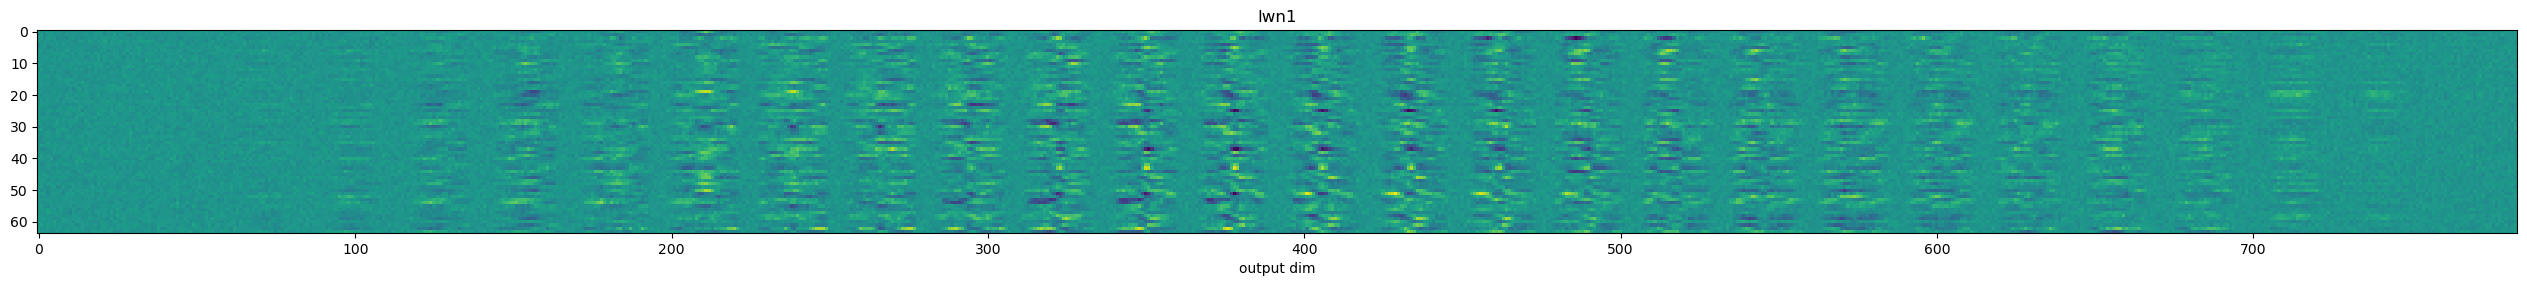

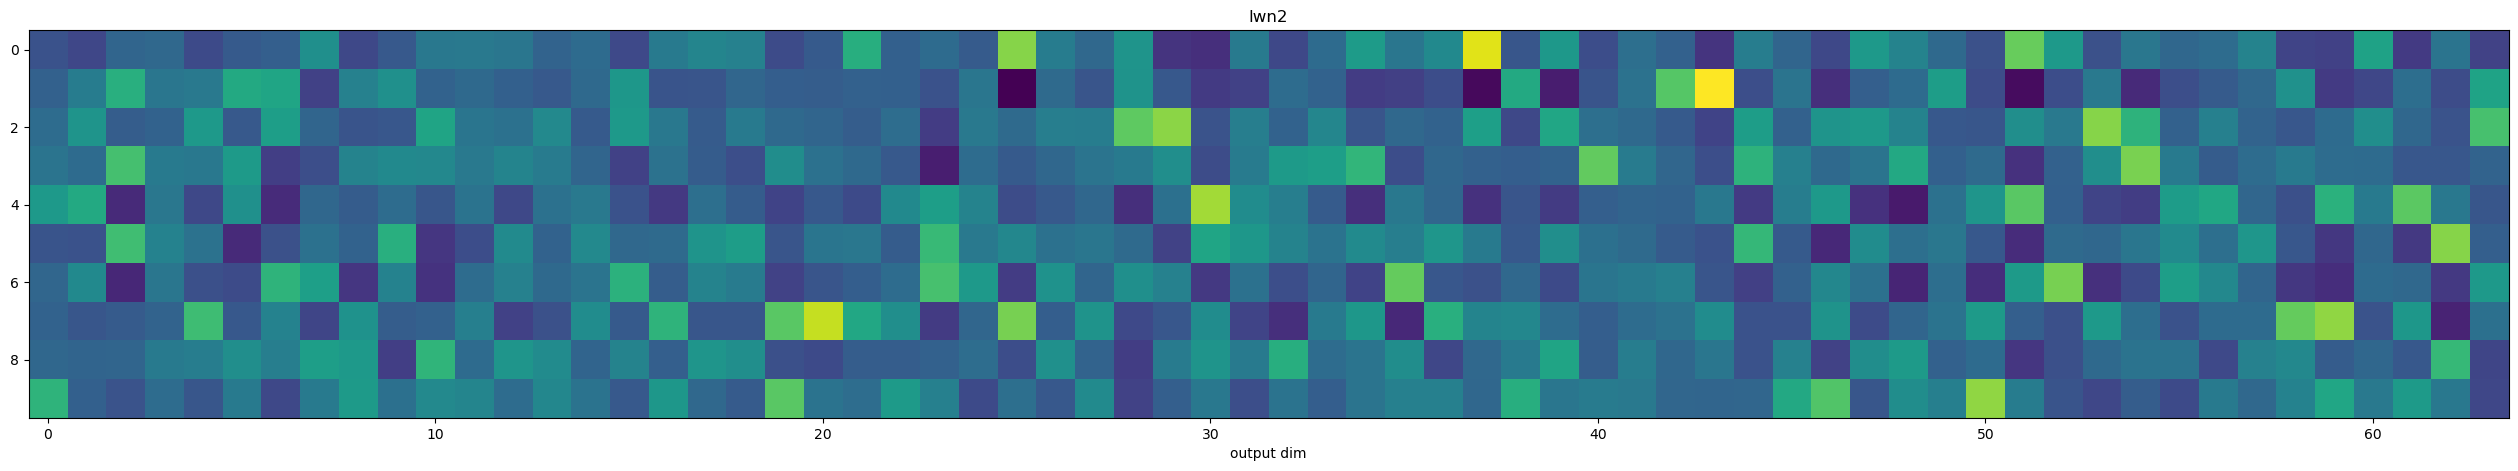

In [9]:
path='./test_model'

stru=pd.read_csv(path+'/model_structure.csv')
print('模型的结构为：')
print(stru)

layer_l=[]
for i in range(stru.shape[0]):
    name=stru.iloc[i,1]
    layer_type='lwn' if 'lwn' in name else 'nonli'
    if layer_type=='lwn':
        layer_shape=[int(i)for i in stru.iloc[i,2][1:-1].split(',')[:-1]]
        bias=('True' in stru.iloc[i,2][1:-1].split(',')[-1])
        layer=linear_with_np(layer_shape[0],layer_shape[1],bias)

        trans_mat=np.load(path+'/{0}+trans.npy'.format(name))
        layer.trans_mat=trans_mat
        if bias:
            bias_mat=np.load(path+'/{0}+bias.npy'.format(name))
            layer.bias_mat=bias_mat
            
        plt.figure(figsize=(32,8))
        plt.title(name)
        plt.imshow(trans_mat)
        plt.xlabel('input dim')
        plt.xlabel('output dim')
        # plt.colorbar()
        plt.show()
    else:
        if 'Leaky' in stru.iloc[i,2]:
            nonli_type,alpha=stru.iloc[i,2].split(' ')
            alpha=float(alpha)
            layer=nonlinear_with_np(nonli_type,alpha)
            
        else:
            nonli_type=stru.iloc[i,2]
            layer=nonlinear_with_np(nonli_type)
    layer_l.append(layer)
    

In [10]:
out=test_set_x
for li in layer_l:
    out=li.forward(out)

test_pred=out.argmax(axis=0)
acc=accuracy_score(test_set_y,test_pred)
R=recall_score(test_set_y,test_pred,average='macro')
P=precision_score(test_set_y,test_pred,average='macro')
F1=f1_score(test_set_y,test_pred,average='macro')

print('最终得到的模型在测试集合上的acc为：{0:.4f}'.format(acc))
print('最终得到的模型在测试集合上的recall为：{0:.4f}'.format(R))
print('最终得到的模型在测试集合上的precision为：{0:.4f}'.format(P))
print('最终得到的模型在测试集合上的f1为：{0:.4f}'.format(F1))

最终得到的模型在测试集合上的acc为：0.9135
最终得到的模型在测试集合上的recall为：0.9121
最终得到的模型在测试集合上的precision为：0.9123
最终得到的模型在测试集合上的f1为：0.9120
